In [32]:
import types
import pandas as pd
import quandl # import data

df_data_1 = quandl.get("OPEC/ORB", start_date="2003-01-01", end_date="2020-06-30")
df_data_1.head()


,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


Data Source

U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, January 10, 2018.

In [82]:
# if data has missing values use below code
# df_data_1 = df_data_1[df_data_1 != "."] 
print (df_data_1.shape)
print(df_data_1)

(4512, 1)
            Value
Date             
2003-01-02  30.05
2003-01-03  30.83
2003-01-06  30.71
2003-01-07  29.72
2003-01-08  28.86
...           ...
2020-06-24  38.17
2020-06-25  37.18
2020-06-26  37.99
2020-06-29  37.34
2020-06-30  38.22

[4512 rows x 1 columns]


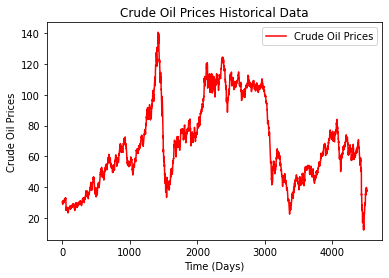

In [83]:
import matplotlib.pyplot as plt
df_data_1_plot = df_data_1.values
# print(df_data_1_plot)
# for i in range(len(df_data_1_plot)):
#     df_data_1_plot[i][0] = float(df_data_1_plot[i][0])
# Visualising the Data
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [84]:
#import packages
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model

In [212]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 1000
timesteps = 5

In [213]:
length = len(df_data_1)
print (length)

#test set will be 10% of entire data set  
length *= 1 - 0.1
print (length)

4512
4060.8


In [214]:
#get the length of training data set 
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print (x)
    return (max(train_length_values))

In [215]:
length = get_train_length(df_data_1, batch_size, 0.1)
print (length)

3968
4032
4032


In [216]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = df_data_1[0:upper_train]
training_set = df_data_1_train.values
training_set.shape

(4042, 1)

In [217]:
# Feature Scaling i.e we scale each and every value between 0 and 1 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(4042, 1)

In [218]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print (length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print (len(X_train))
print (len (y_train))
print (np.array(X_train).shape)
print (np.array(y_train).shape)

4037
4032
4032
(4032, 5)
(4032, 5)


In [219]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print (X_train.shape)
print (y_train.shape)

(4032, 5, 1)
(4032, 5, 1)


In [220]:
# Building the LSTM
# Importing the Keras libraries and packages

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.models import Model
import h5py

In [221]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(64, 5, 1)]              0         
_________________________________________________________________
lstm_18 (LSTM)               (64, 5, 10)               480       
_________________________________________________________________
lstm_19 (LSTM)               (64, 5, 10)               840       
_________________________________________________________________
dense_9 (Dense)              (64, 5, 1)                11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [222]:
# 1st LSTM Layer 
parameters = 4 * 10 * (1 + 10 + 1)
print (parameters)

480


In [223]:
# 2nd LSTM Layer 
parameters = 4 * 10 * (10 + 10 + 1)
print( parameters)

840


In [224]:
print("Epoch: " + str(epochs))
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 1000
Epoch: 0
4032/4032 [==============================] - 3s 827us/sample - loss: 0.1723
Epoch: 1
4032/4032 [==============================] - 1s 245us/sample - loss: 0.1496
Epoch: 2
4032/4032 [==============================] - 1s 226us/sample - loss: 0.1240
Epoch: 3
4032/4032 [==============================] - 1s 226us/sample - loss: 0.1158s - loss: 
Epoch: 4
4032/4032 [==============================] - 1s 231us/sample - loss: 0.1089
Epoch: 5
4032/4032 [==============================] - 1s 233us/sample - loss: 0.1016
Epoch: 6
4032/4032 [==============================] - 1s 253us/sample - loss: 0.0947
Epoch: 7
4032/4032 [==============================] - 1s 241us/sample - loss: 0.0869
Epoch: 8
4032/4032 [==============================] - 1s 228us/sample - loss: 0.0831
Epoch: 9
4032/4032 [==============================] - 1s 227us/sample - loss: 0.0773
Epoch: 10
4032/4032 [==============================] - 1s 225us/sample - loss: 0.0733
Epoch: 11
4032/4032 [=====================

4032/4032 [==============================] - 1s 230us/sample - loss: 0.0239
Epoch: 95
4032/4032 [==============================] - 1s 225us/sample - loss: 0.0237
Epoch: 96
4032/4032 [==============================] - 1s 250us/sample - loss: 0.0236
Epoch: 97
4032/4032 [==============================] - 1s 287us/sample - loss: 0.0235
Epoch: 98
4032/4032 [==============================] - 1s 252us/sample - loss: 0.0234
Epoch: 99
4032/4032 [==============================] - 1s 245us/sample - loss: 0.0234
Epoch: 100
4032/4032 [==============================] - 1s 252us/sample - loss: 0.0233
Epoch: 101
4032/4032 [==============================] - 1s 245us/sample - loss: 0.0232
Epoch: 102
4032/4032 [==============================] - 1s 259us/sample - loss: 0.0231s - loss: 0.
Epoch: 103
4032/4032 [==============================] - 1s 235us/sample - loss: 0.0230
Epoch: 104
4032/4032 [==============================] - 1s 236us/sample - loss: 0.0230
Epoch: 105
4032/4032 [=========================

4032/4032 [==============================] - 1s 246us/sample - loss: 0.0216
Epoch: 188
4032/4032 [==============================] - 1s 241us/sample - loss: 0.0211
Epoch: 189
4032/4032 [==============================] - 1s 270us/sample - loss: 0.0216
Epoch: 190
4032/4032 [==============================] - 1s 241us/sample - loss: 0.0214
Epoch: 191
4032/4032 [==============================] - 1s 237us/sample - loss: 0.0220
Epoch: 192
4032/4032 [==============================] - 1s 274us/sample - loss: 0.0209
Epoch: 193
4032/4032 [==============================] - 1s 225us/sample - loss: 0.0220
Epoch: 194
4032/4032 [==============================] - 1s 234us/sample - loss: 0.0211
Epoch: 195
4032/4032 [==============================] - 1s 267us/sample - loss: 0.0222
Epoch: 196
4032/4032 [==============================] - 1s 251us/sample - loss: 0.0208
Epoch: 197
4032/4032 [==============================] - 1s 251us/sample - loss: 0.0221
Epoch: 198
4032/4032 [==============================] 

Epoch: 281
4032/4032 [==============================] - 1s 266us/sample - loss: 0.0214
Epoch: 282
4032/4032 [==============================] - 1s 241us/sample - loss: 0.0202
Epoch: 283
4032/4032 [==============================] - 1s 258us/sample - loss: 0.0212
Epoch: 284
4032/4032 [==============================] - 1s 223us/sample - loss: 0.0201
Epoch: 285
4032/4032 [==============================] - 1s 246us/sample - loss: 0.0212
Epoch: 286
4032/4032 [==============================] - 1s 249us/sample - loss: 0.0202
Epoch: 287
4032/4032 [==============================] - 1s 274us/sample - loss: 0.0210
Epoch: 288
4032/4032 [==============================] - 1s 312us/sample - loss: 0.0198
Epoch: 289
4032/4032 [==============================] - 1s 265us/sample - loss: 0.0209
Epoch: 290
4032/4032 [==============================] - 1s 245us/sample - loss: 0.0198
Epoch: 291
4032/4032 [==============================] - 1s 242us/sample - loss: 0.0209
Epoch: 292
4032/4032 [=====================

Epoch: 375
4032/4032 [==============================] - 1s 223us/sample - loss: 0.0197
Epoch: 376
4032/4032 [==============================] - 1s 223us/sample - loss: 0.0198
Epoch: 377
4032/4032 [==============================] - 1s 243us/sample - loss: 0.0198
Epoch: 378
4032/4032 [==============================] - 1s 225us/sample - loss: 0.0198
Epoch: 379
4032/4032 [==============================] - 1s 224us/sample - loss: 0.0198
Epoch: 380
4032/4032 [==============================] - 1s 222us/sample - loss: 0.0198
Epoch: 381
4032/4032 [==============================] - 1s 230us/sample - loss: 0.0197
Epoch: 382
4032/4032 [==============================] - 1s 250us/sample - loss: 0.0198
Epoch: 383
4032/4032 [==============================] - 1s 286us/sample - loss: 0.0199
Epoch: 384
4032/4032 [==============================] - 1s 283us/sample - loss: 0.0199
Epoch: 385
4032/4032 [==============================] - 1s 242us/sample - loss: 0.0200
Epoch: 386
4032/4032 [=====================

4032/4032 [==============================] - 1s 223us/sample - loss: 0.0195
Epoch: 469
4032/4032 [==============================] - 1s 228us/sample - loss: 0.0195
Epoch: 470
4032/4032 [==============================] - 1s 227us/sample - loss: 0.0195
Epoch: 471
4032/4032 [==============================] - 1s 226us/sample - loss: 0.0196
Epoch: 472
4032/4032 [==============================] - 1s 251us/sample - loss: 0.0197
Epoch: 473
4032/4032 [==============================] - 1s 226us/sample - loss: 0.0197
Epoch: 474
4032/4032 [==============================] - 1s 222us/sample - loss: 0.0197
Epoch: 475
4032/4032 [==============================] - 1s 236us/sample - loss: 0.0197
Epoch: 476
4032/4032 [==============================] - 1s 288us/sample - loss: 0.0197
Epoch: 477
4032/4032 [==============================] - 1s 290us/sample - loss: 0.0197
Epoch: 478
4032/4032 [==============================] - 1s 312us/sample - loss: 0.0197
Epoch: 479
4032/4032 [==============================] 

Epoch: 562
4032/4032 [==============================] - 1s 297us/sample - loss: 0.0192
Epoch: 563
4032/4032 [==============================] - 1s 271us/sample - loss: 0.0188
Epoch: 564
4032/4032 [==============================] - 1s 279us/sample - loss: 0.0201
Epoch: 565
4032/4032 [==============================] - 2s 390us/sample - loss: 0.0196
Epoch: 566
4032/4032 [==============================] - 1s 321us/sample - loss: 0.0213
Epoch: 567
4032/4032 [==============================] - 1s 348us/sample - loss: 0.0185
Epoch: 568
4032/4032 [==============================] - 1s 316us/sample - loss: 0.0195
Epoch: 569
4032/4032 [==============================] - 1s 339us/sample - loss: 0.0182s - loss: 0.0
Epoch: 570
4032/4032 [==============================] - 1s 302us/sample - loss: 0.0190
Epoch: 571
4032/4032 [==============================] - 1s 356us/sample - loss: 0.0191
Epoch: 572
4032/4032 [==============================] - 1s 311us/sample - loss: 0.0209
Epoch: 573
4032/4032 [========

4032/4032 [==============================] - 1s 255us/sample - loss: 0.0199
Epoch: 656
4032/4032 [==============================] - 1s 256us/sample - loss: 0.0212
Epoch: 657
4032/4032 [==============================] - 1s 252us/sample - loss: 0.0210s - loss: 0
Epoch: 658
4032/4032 [==============================] - 1s 306us/sample - loss: 0.0304
Epoch: 659
4032/4032 [==============================] - 1s 262us/sample - loss: 0.0188
Epoch: 660
4032/4032 [==============================] - 1s 315us/sample - loss: 0.0182
Epoch: 661
4032/4032 [==============================] - 1s 252us/sample - loss: 0.0189
Epoch: 662
4032/4032 [==============================] - 1s 251us/sample - loss: 0.0194
Epoch: 663
4032/4032 [==============================] - 1s 290us/sample - loss: 0.0219
Epoch: 664
4032/4032 [==============================] - 1s 274us/sample - loss: 0.0210
Epoch: 665
4032/4032 [==============================] - 1s 228us/sample - loss: 0.0183
Epoch: 666
4032/4032 [=====================

4032/4032 [==============================] - 1s 264us/sample - loss: 0.0200
Epoch: 749
4032/4032 [==============================] - 1s 262us/sample - loss: 0.0198
Epoch: 750
4032/4032 [==============================] - 1s 296us/sample - loss: 0.0197
Epoch: 751
4032/4032 [==============================] - 1s 259us/sample - loss: 0.0195
Epoch: 752
4032/4032 [==============================] - 1s 290us/sample - loss: 0.0192
Epoch: 753
4032/4032 [==============================] - 1s 278us/sample - loss: 0.0189s - loss: 0.0
Epoch: 754
4032/4032 [==============================] - 1s 257us/sample - loss: 0.0187
Epoch: 755
4032/4032 [==============================] - 1s 267us/sample - loss: 0.0185
Epoch: 756
4032/4032 [==============================] - 1s 275us/sample - loss: 0.0184
Epoch: 757
4032/4032 [==============================] - 1s 249us/sample - loss: 0.0184
Epoch: 758
4032/4032 [==============================] - 1s 235us/sample - loss: 0.0185
Epoch: 759
4032/4032 [===================

4032/4032 [==============================] - 1s 290us/sample - loss: 0.0186
Epoch: 842
4032/4032 [==============================] - 1s 256us/sample - loss: 0.0182
Epoch: 843
4032/4032 [==============================] - 1s 282us/sample - loss: 0.0182
Epoch: 844
4032/4032 [==============================] - 1s 293us/sample - loss: 0.0182
Epoch: 845
4032/4032 [==============================] - 1s 271us/sample - loss: 0.0182
Epoch: 846
4032/4032 [==============================] - 1s 286us/sample - loss: 0.0182
Epoch: 847
4032/4032 [==============================] - 1s 246us/sample - loss: 0.0182
Epoch: 848
4032/4032 [==============================] - 1s 233us/sample - loss: 0.0182
Epoch: 849
4032/4032 [==============================] - 1s 237us/sample - loss: 0.0182
Epoch: 850
4032/4032 [==============================] - 1s 231us/sample - loss: 0.0182
Epoch: 851
4032/4032 [==============================] - 1s 236us/sample - loss: 0.0182
Epoch: 852
4032/4032 [==============================] 

4032/4032 [==============================] - 1s 252us/sample - loss: 0.0184
Epoch: 936
4032/4032 [==============================] - 1s 307us/sample - loss: 0.0187
Epoch: 937
4032/4032 [==============================] - 1s 278us/sample - loss: 0.0181
Epoch: 938
4032/4032 [==============================] - 1s 267us/sample - loss: 0.0179
Epoch: 939
4032/4032 [==============================] - 1s 252us/sample - loss: 0.0175
Epoch: 940
4032/4032 [==============================] - 1s 298us/sample - loss: 0.0173
Epoch: 941
4032/4032 [==============================] - 1s 258us/sample - loss: 0.0173
Epoch: 942
4032/4032 [==============================] - 1s 249us/sample - loss: 0.0170
Epoch: 943
4032/4032 [==============================] - 1s 289us/sample - loss: 0.0171
Epoch: 944
4032/4032 [==============================] - 1s 250us/sample - loss: 0.0172s - loss: 0
Epoch: 945
4032/4032 [==============================] - 1s 247us/sample - loss: 0.0174s - loss - ETA: 0s - loss: 0.
Epoch: 946
403

In [225]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print (x)
    return (max(test_length_values))

In [226]:
test_length = get_test_length(df_data_1, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print (testset_length)

4362
4426
4490
4490
448


In [227]:
print (upper_train, upper_test, len(df_data_1))

4042 4500 4512


In [228]:
# construct test set

#subsetting
df_data_1_test = df_data_1[upper_train:upper_test] 
test_set = df_data_1_test.values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [229]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print (predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print (predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print (y_test.shape)

(448, 5, 1)
(448, 5)
(443, 1)


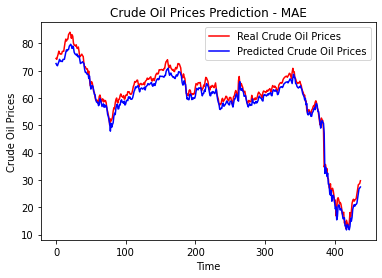

In [230]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)], color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_test[0:len(y_test) - timesteps], color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [231]:

import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

2.338725747531054


In [232]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

1.988993456243924
